In [1]:
import tensorflow as tf
import pandas as pa
import numpy as np
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256;
BATCH_SIZE = 32;
CHANNELS=3
EPOCHS=10;

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
   "PlantVillage",
    shuffle =True,
    image_size= (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
    

)

Found 2152 files belonging to 3 classes.


In [4]:
class_names= dataset.class_names

In [5]:
len(dataset)

68

In [6]:
train_size= 0.8
len (dataset)*train_size

54.400000000000006

In [7]:
test_ds= dataset.skip(54)
len(test_ds)

14

In [8]:
val_size=0.1;
len(dataset)*val_size

6.800000000000001

In [9]:
def get_dataset_partition_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1,shuffle=True, shuffle_size=10000):
    ds_size = len(ds);
    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=12)
    
    train_size= int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    val_ds= ds.skip(train_size).take(val_size)
    test_ds= ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds,test_ds

In [10]:
train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset)

In [11]:
len(train_ds)

54

In [12]:
len(val_ds)

6

In [13]:
len(test_ds)

8

In [14]:
train_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds= val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds= test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
resize_and_rescale= tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
    
])

In [16]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
    
])

In [17]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE, CHANNELS)
n_classes=3


model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64 ,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape= input_shape)

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [19]:
model.compile(
    optimizer= 'adam',
    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [20]:
history = model.fit(
    train_ds,
    epochs= EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 [==============================] - 21s 183ms/step - loss: 0.8498 - accuracy: 0.5446 - val_loss: 0.8358 - val_accuracy: 0.6458
Epoch 2/50
54/54 [==============================] - 9s 159ms/step - loss: 0.4422 - accuracy: 0.8241 - val_loss: 0.2569 - val_accuracy: 0.8750
Epoch 3/50
54/54 [==============================] - 9s 159ms/step - loss: 0.2640 - accuracy: 0.8929 - val_loss: 0.3329 - val_accuracy: 0.8802
Epoch 4/50
54/54 [==============================] - 8s 156ms/step - loss: 0.2565 - accuracy: 0.8935 - val_loss: 0.1520 - val_accuracy: 0.9427
Epoch 5/50
54/54 [==============================] - 9s 159ms/step - loss: 0.1957 - accuracy: 0.9259 - val_loss: 0.1385 - val_accuracy: 0.9740
Epoch 6/50
54/54 [==============================] - 8s 156ms/step - loss: 0.1459 - accuracy: 0.9485 - val_loss: 0.1098 - val_accuracy: 0.9688
Epoch 7/50
54/54 [==============================] - 8s 156ms/step - loss: 0.1150 - accuracy: 0.9612 - val_loss: 0.1253 - val_accuracy: 0.9531
Epoch

In [21]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 1s 29ms/step - loss: 0.1157 - accuracy: 0.9648


actual label: Potato___Early_blight
1/1 [==============================] - 0s 36ms/step
predicted label: Potato___Early_blight


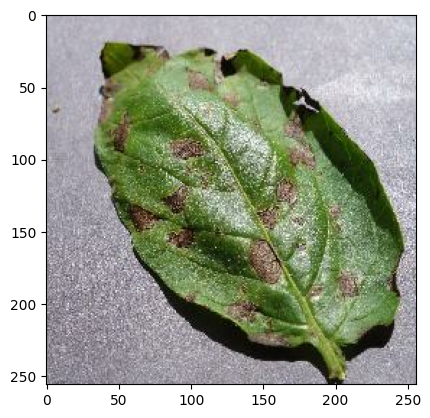

In [43]:
for images_batch, labels_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    plt.imshow(first_image)
    print('actual label:',class_names[first_label])
    
    batch_prediction= model.predict(images_batch)
    print('predicted label:',class_names[np.argmax(batch_prediction[0])])

In [45]:
def predict(model,img):
    img_array=tf.keras.preprocessing.img.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)
    
    prediction = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(prediction[0])]
    confidence= round(100*(np.argmax(prediction[0])),2)
    
    return predicted_class, confidence

In [49]:
model_version = 1
model.save(f"../model/{model_version}")

INFO:tensorflow:Assets written to: ../model/1\assets


INFO:tensorflow:Assets written to: ../model/1\assets
